In [362]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Proyecto de grado-Extensión/Registro de Nubes/Registro de Nubes')
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1bUVmxKZXlCNnu4CbA53Po31b084HWCvL/Registro de Nubes


In [363]:
import os
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt

In [364]:
#segundo modelo entrenado
os.chdir('/content/drive/MyDrive/PROYECTO DE GRADO/Code/DPDist-master/log/lastTrain')

## Datos


In [365]:
def read_pc_by_class(num_point_Clouds, num_points, clase, inicial_path):
  import random
  r = random.randint(0, 20)
  lista = []
  path_i = inicial_path + '/' + clase + '/' + clase +'_'
  
  for i in range(1, num_point_Clouds+1):
    if(i<10):
      path = path_i + '00' + str(0)+str(i) + '.txt'
    if(i>=10 and i<100):
      path = path_i + '00' + str(i) + '.txt'
    if(i>=100 and i<1000):
      path = path_i + '0' + str(i) + '.txt'
    if(i>=1000):
      path = path_i + str(i) + '.txt'
    pC = np.loadtxt(path, delimiter=',', usecols=(0,1,2))
    pC = pC[r*100:r*100+num_points, :]
    lista.append(pC)



  return lista


In [366]:
def rotation_matrix(theta):
    return np.array([[np.cos(theta),-np.sin(theta), 0],
                     [np.sin(theta),np.cos(theta), 0],
                     [0,0,1]])

In [509]:
chair = read_pc_by_class(20, 5000, 'bed', '../../data/modelnet40_normal_resampled')

In [368]:
guitar = read_pc_by_class(10, 5000, 'guitar', '../../data/modelnet40_normal_resampled')

In [369]:
nube = chair[2]
SA = nube[:1024,:]
SB =  chair[2][2048:3072,:]

## DPDist

In [370]:
def get_bn_decay(batch):
  bn_momentum = tf.train.exponential_decay(
                                            0.5,
                                            batch,#*BATCH_SIZE,
                                            float(0.5),
                                            0.5,
                                            staircase=True)

In [371]:
def initialize_uninitialized_vars(sess):
    from itertools import compress
    global_vars = tf.global_variables()
    is_not_initialized = sess.run([~(tf.is_variable_initialized(var)) \
                                   for var in global_vars])
    not_initialized_vars = list(compress(global_vars, is_not_initialized))

    if len(not_initialized_vars):
        print('init not_initialized')
        print(not_initialized_vars)
        sess.run(tf.variables_initializer(not_initialized_vars))

In [372]:
def DPDIST(nubeA, nubeB):
  import tensorflow.compat.v1 as tf
  input_1 = nubeA.reshape(16, 64, SB.shape[1])
  input_2 = nubeB.reshape(16,  64 ,SA.shape[1])
  noise = np.zeros((16, 64, 3))
  from tensorflow.python.framework import meta_graph
  graph = tf.Graph()
  with graph.as_default():
    with tf.device('/gpu:' + str(0)):
        batch = tf.get_variable('batch', [], initializer=tf.constant_initializer(0), trainable=False)
        #bn_decay = get_bn_decay(batch)
        #tf.summary.scalar('bn_decay', bn_decay) 
        is_training_pl_1 = tf.placeholder(tf.bool, shape=())
        is_training_pl_2 = tf.placeholder(tf.bool, shape=())
        x1 = tf.placeholder(tf.float32, (16, 64,3), name='input1')
        x2 = tf.placeholder(tf.float32, (16, 64,3), name='input2')
        x3 = tf.placeholder(tf.float32, (16, 64,3), name='input3')
        saver31 = tf.train.import_meta_graph('./model.ckpt.meta',
                                            import_scope='g1',
                                            input_map={'input1': x1,
                                                      'input2': x2,
                                                      'Placeholder': is_training_pl_1,
                                                      'add_noise':x3}
                                            )
        labels12 = graph.get_tensor_by_name('g1/labels12:0')
        pred_AB3 = (graph.get_tensor_by_name('g1/pc_compare/output1:0'))
        pred_BA3 = (graph.get_tensor_by_name('g1/pc_compare/output2:0'))
        loss_p = (tf.reduce_mean(pred_AB3[:,:,:,0]) + tf.reduce_mean(pred_BA3[:,:,:,0]))/2.0
    # Create a session
    init = tf.global_variables_initializer()
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    config.log_device_placement = False
    sess3 = tf.InteractiveSession(config=config)
    sess3.run(init)
    #DPDist weights loader
    MODEL_PATH = './model.ckpt'
    saver31.restore(sess3, MODEL_PATH)
    initialize_uninitialized_vars(sess3)
    #print('model restored')
    ops3 = {'x1':x1,
            'x2':x2,
            'add_noise':x3,
            # 'pc_Crec':pc_Crec,
            'is_training_pl1':is_training_pl_1,
            'loss':loss_p,
            'labels12':labels12,
            'pred': {'pred_AB':pred_AB3,'pred_BA':pred_BA3}}

    feed_dict={ops3['x1']:input_1,
              ops3['x2']: input_2,
              ops3['is_training_pl1']:False,
              ops3['add_noise']:noise,
              # train_opt_pred3:True,
              }        
    result =sess3.run([ops3['pred']], feed_dict=feed_dict)
    '''
    resultBA=sess3.run(pred_BA3, feed_dict=feed_dict_testing)
    resultAB_0 = resultAB[:,:,:,:]
    resultBA_0 = resultBA[:,:,:,:]  
    resultAB_0 = resultAB_0.reshape(1024,3)
    resultBA_0 = resultAB_0.reshape(1024,3)
    '''
    sess3.close()
    result = np.array(result)
    DistAB = result[0]['pred_AB']
    vDistAB = DistAB.reshape(1024,3)
    DistBA = result[0]['pred_BA']
    vDistBA = DistBA.reshape(1024,3)
  return vDistAB[:,0], vDistBA[:,0],  #vectores de distanciaAB, #vectores de distanciaBA

In [373]:
def get_bn_decay(batch):
  bn_momentum = tf.train.exponential_decay(
                                            0.5,
                                            batch,#*BATCH_SIZE,
                                            float(0.5),
                                            0.5,
                                            staircase=True)

In [374]:
def initialize_uninitialized_vars(sess):
    from itertools import compress
    global_vars = tf.global_variables()
    is_not_initialized = sess.run([~(tf.is_variable_initialized(var)) \
                                   for var in global_vars])
    not_initialized_vars = list(compress(global_vars, is_not_initialized))

    if len(not_initialized_vars):
        print('init not_initialized')
        print(not_initialized_vars)
        sess.run(tf.variables_initializer(not_initialized_vars))

In [375]:
def DPDISTnormaAndDistPc_Pc(vectorDistAB, vectorDistBA):
  '''
  DPDistanceABmap = []
  for i in range(len(vectorDistAB)):
    DPDistanceAB = np.linalg.norm(vectorDistAB[i,:])
    DPDistanceABmap.append(DPDistanceAB)
  '''
  DPDistanceABmap = np.array(vectorDistAB)
  '''
  DPDistanceBAmap = []
  for i in range(len(vectorDistBA)):
    DPDistanceBA= np.linalg.norm(vectorDistBA[i,:])
    DPDistanceBAmap.append(DPDistanceBA)
  '''
  DPDistanceBAmap = np.array(vectorDistAB)
  #dist_pcA_pcB=((1/SA.shape[0])*np.sum(DPDistanceABmap))+((1/SB.shape[0])*np.sum(DPDistanceBAmap))
  dist_pcA_pcB2=((1/SA.shape[0])*np.sum(vectorDistAB))+((1/SB.shape[0])*np.sum(vectorDistAB))
  return DPDistanceABmap, DPDistanceBAmap, round(dist_pcA_pcB2, 4) #normaVectoresAB, #normaVectoresBA, #distancia de nube a nube 

## Funciones de rotación

In [376]:
import math
from functools import reduce
import numpy as np
def rotacionZXY(radz, rady, radx):
  Ms = []
  z= radz
  y= rady
  x= radx

  cosz = math.cos(z)
  sinz = math.sin(z)
  Ms.append(np.array(
          [[cosz, -sinz, 0],
            [sinz, cosz, 0],
            [0, 0, 1]]))
  
  cosx = math.cos(x)
  sinx = math.sin(x)
  Ms.append(np.array(
          [[1, 0, 0],
            [0, cosx, -sinx],
            [0, sinx, cosx]]))

  cosy = math.cos(y)
  siny = math.sin(y)
  Ms.append(np.array(
          [[cosy, 0, siny],
            [0, 1, 0],
            [-siny, 0, cosy]]))

  Mzxy = reduce(np.dot, Ms[::-1])
  return Mzxy

In [377]:
def rotacionXYZ(radz, rady, radx):
  Ms = []
  z= radz
  y= rady
  x= radx
  cosx = math.cos(x)
  sinx = math.sin(x)
  Ms.append(np.array(
          [[1, 0, 0],
            [0, cosx, -sinx],
            [0, sinx, cosx]]))
  
  cosy = math.cos(y)
  siny = math.sin(y)
  Ms.append(np.array(
          [[cosy, 0, siny],
            [0, 1, 0],
            [-siny, 0, cosy]]))
  
  cosz = math.cos(z)
  sinz = math.sin(z)
  Ms.append(np.array(
          [[cosz, -sinz, 0],
            [sinz, cosz, 0],
            [0, 0, 1]]))
  

  Mxyz = reduce(np.dot, Ms[::-1])
  return Mxyz

In [378]:
def rotacionXZY(radz, rady, radx):
  Ms = []
  z= radz
  y= rady
  x= radx
  cosx = math.cos(x)
  sinx = math.sin(x)
  Ms.append(np.array(
          [[1, 0, 0],
            [0, cosx, -sinx],
            [0, sinx, cosx]]))
  
  cosz = math.cos(z)
  sinz = math.sin(z)
  Ms.append(np.array(
          [[cosz, -sinz, 0],
            [sinz, cosz, 0],
            [0, 0, 1]]))  
  cosy = math.cos(y)
  siny = math.sin(y)
  Ms.append(np.array(
          [[cosy, 0, siny],
            [0, 1, 0],
            [-siny, 0, cosy]]))
  

  

  Mxzy = reduce(np.dot, Ms[::-1])
  return Mxzy

In [379]:
def rotacionYXZ(radz, rady, radx):
  Ms = []
  z= radz
  y= rady
  x= radx

  cosy = math.cos(y)
  siny = math.sin(y)
  Ms.append(np.array(
          [[cosy, 0, siny],
            [0, 1, 0],
            [-siny, 0, cosy]]))  
  
  cosx = math.cos(x)
  sinx = math.sin(x)
  Ms.append(np.array(
          [[1, 0, 0],
            [0, cosx, -sinx],
            [0, sinx, cosx]]))
  
  cosz = math.cos(z)
  sinz = math.sin(z)
  Ms.append(np.array(
          [[cosz, -sinz, 0],
            [sinz, cosz, 0],
            [0, 0, 1]]))  


  

  Myxz = reduce(np.dot, Ms[::-1])
  return Myxz

In [380]:
def rotacionYZX(radz, rady, radx):
  Ms = []
  z= radz
  y= rady
  x= radx

  cosy = math.cos(y)
  siny = math.sin(y)
  Ms.append(np.array(
          [[cosy, 0, siny],
            [0, 1, 0],
            [-siny, 0, cosy]]))  
  cosz = math.cos(z)
  sinz = math.sin(z)
  Ms.append(np.array(
          [[cosz, -sinz, 0],
            [sinz, cosz, 0],
            [0, 0, 1]]))  
  cosx = math.cos(x)
  sinx = math.sin(x)
  Ms.append(np.array(
          [[1, 0, 0],
            [0, cosx, -sinx],
            [0, sinx, cosx]]))
  

  

  Myzx = reduce(np.dot, Ms[::-1])
  return Myzx

In [381]:
import math
from functools import reduce
import numpy as np
def rotacionZYX(radz, rady, radx):
  Ms = []
  z= radz
  y= rady
  x= radx

  cosz = math.cos(z)
  sinz = math.sin(z)
  Ms.append(np.array(
          [[cosz, -sinz, 0],
            [sinz, cosz, 0],
            [0, 0, 1]]))

  cosy = math.cos(y)
  siny = math.sin(y)
  Ms.append(np.array(
          [[cosy, 0, siny],
            [0, 1, 0],
            [-siny, 0, cosy]]))

  cosx = math.cos(x)
  sinx = math.sin(x)
  Ms.append(np.array(
          [[1, 0, 0],
            [0, cosx, -sinx],
            [0, sinx, cosx]]))


  Mzyx = reduce(np.dot, Ms[::-1])
  return Mzyx

In [382]:
def rotation_matrix(theta):
    return np.array([[1,0, 0],
                     [0,np.cos(theta), -np.sin(theta)],
                     [0,np.sin(theta), np.cos(theta)]])

In [383]:
def Y_axis_rotation_matrix(theta):
    return np.array([[np.cos(theta),  0,  np.sin(theta)],
                     [0,              1,              0],
                     [-np.sin(theta), 0,  np.cos(theta)]])

In [384]:
def Z_axis_rotation_matrix(theta):
    return np.array([[np.cos(theta),   -np.sin(theta),    0],
                     [np.sin(theta),    np.cos(theta),    0],
                     [0,                0,                1]])

## DPDist vs Rotaciones

In [385]:
def DPDist_vs_rotaciones(point_cloudA, point_cloudB, ejex: bool, ejey: bool, ejez: bool, num_puntos):
  DistAB_l = [] 
  DistBA_l = []
  DistPC_PC_l = []
  DistAB_list = [] 
  DistBA_list = []
  DistPC_PC_list = []
  dist_mia_l = []
  rotation = []
 
  for i in range(1):
    nubeA= point_cloudA
    nubeB = point_cloudB
    point_cloud_A = nubeA
    r = 2*np.pi
    c = 0
    if(ejex==True and ejey==False and ejez==False):
      for j in range(num_puntos+1):
        if(j==0):
          R=2*np.pi
        else:
          R = r - np.pi/(np.round(num_puntos/2))
        Rm = rotation_matrix(R)   
        point_cloud_B= np.dot(Rm, nubeB.T).T 
        rotation.append(R)
        r=R
        vectDistAB, vectDistBA = DPDIST(point_cloud_A, point_cloud_B)
        normAB, normBA, DistPC_PC = DPDISTnormaAndDistPc_Pc(vectDistAB, vectDistBA)
        c = DistPC_PC
        DistPC_PC_l.append(c)
      
    if(ejex==False and ejey==True and ejez==False):
      for j in range(num_puntos+1):
        if(j==0):
          R=2*np.pi
        else:
          R = r - np.pi/(np.round(num_puntos/2))
        Rm = Y_axis_rotation_matrix(R)   
        point_cloud_B= np.dot(Rm, nubeB.T).T 
        rotation.append(R)
        r=R
        vectDistAB, vectDistBA = DPDIST(point_cloud_A, point_cloud_B)
        normAB, normBA, DistPC_PC = DPDISTnormaAndDistPc_Pc(vectDistAB, vectDistBA)
        c = DistPC_PC
        DistPC_PC_l.append(c)
     
    if(ejex==False and ejey==False and ejez==True):
      for j in range(num_puntos+1):
        print(j)
        if(j==0):
          R=2*np.pi
        else:
          R = r - np.pi/(np.round(num_puntos/2))
        Rm = Z_axis_rotation_matrix(R)   
        point_cloud_B= np.dot(Rm, nubeB.T).T 
        rotation.append(R)
        r=R
        vectDistAB, vectDistBA = DPDIST(point_cloud_A, point_cloud_B)
        normAB, normBA, DistPC_PC = DPDISTnormaAndDistPc_Pc(vectDistAB, vectDistBA)
        c = DistPC_PC
        DistPC_PC_l.append(c)
        '''if (j ==num_puntos):
         
          vectDistAB, vectDistBA = DPDIST(nubeA, nubeB)
          normAB, normBA, DistPC_PC = DPDISTnormaAndDistPc_Pc(vectDistAB, vectDistBA)
         
          c = DistPC_PC
          DistPC_PC_l.append(c)'''
    
    if(ejex==True and ejey==True and ejez==True):
        print('codigo aun no implementado')
  print(DistPC_PC_l)      
  grados = []
  r = 2*np.pi
  for i in range(len(rotation)):
    temp = rotation[i] 
    g = (temp)*(180/np.pi)
    #temp = r
    grados.append(g)
  #grados.append(0)
  DPDistAB_arry=[]
  grados_arry = []
  for i in range(0, len(DistPC_PC_l), num_puntos):
    l = DistPC_PC_l[i:i+num_puntos]
    DPDistAB_arry.append(l)
    m = grados[i:i+num_puntos]
    grados_arry.append(m)
 # grados.append(0)
    if(j==num_puntos):
      grados_arry.append(0.0)
  DPDistAB_arry = np.array(DPDistAB_arry)
  grados_arry =  np.array(grados_arry)

  return np.array(DistPC_PC_l), np.array(rotation)

In [386]:
def generar_nubes_rotadas(point_cloud_org, ejex: bool, ejey: bool, ejez: bool, anguloxPCA, anguloyPCA, angulozPCA, anguloxPCB, anguloyPCB, angulozPCB, orden):
  SA = point_cloud_org[:1024,:]
  SB = point_cloud_org[2048:3072,:]
  RxPCA = anguloxPCA
  RyPCA = anguloyPCA
  RzPCA = angulozPCA
  RxPCB = anguloxPCB
  RyPCB = anguloyPCB
  RzPCB = angulozPCB
  if(ejex==True and ejey==False and ejez==False):
    RmPCA = rotation_matrix(RxPCA)   
    RmPCB = rotation_matrix(RxPCB)   
    point_cloudB= np.dot(RmPCB, SB.T).T 
    point_cloudA= np.dot(RmPCA, SA.T).T 
  if(ejex==False and ejey==True and ejez==False):
    RmPCA = Y_axis_rotation_matrix(RyPCA)   
    RmPCB = Y_axis_rotation_matrix(RyPCB)   
    point_cloudB= np.dot(RmPCB, SB.T).T 
    point_cloudA= np.dot(RmPCA, SA.T).T 
  if(ejex==False and ejey==False and ejez==True):
    RmPCA = Z_axis_rotation_matrix(RzPCA)   
    RmPCB = Z_axis_rotation_matrix(RzPCB)   
    point_cloudB= np.dot(RmPCB, SB.T).T 
    point_cloudA= np.dot(RmPCA, SA.T).T 
  if(ejex==True and ejey==True and ejez==True):
    if(orden=='ZYX'):
      RzyxPCA = rotacionZYX(RzPCA, RyPCA, RxPCA)
      RzyxPCB = rotacionZYX(RzPCB, RyPCB, RxPCB)
      point_cloudB= np.dot(RzyxPCB, SB.T).T 
      point_cloudA= np.dot(RzyxPCA, SA.T).T 
    if(orden=='ZXY'):
      RzxyPCA = rotacionZXY(RzPCA, RyPCA, RxPCA)
      RzxyPCB = rotacionZXY(RzPCB, RyPCB, RxPCB)
      point_cloudB= np.dot(RzxyPCB, SB.T).T 
      point_cloudA= np.dot(RzxyPCA, SA.T).T 
    if(orden=='YXZ'):
      RyxzPCA = rotacionYXZ(RzPCA, RyPCA, RxPCA)
      RyxzPCB = rotacionYXZ(RzPCB, RyPCB, RxPCB)
      point_cloudB= np.dot(RyxzPCB, SB.T).T 
      point_cloudA= np.dot(RyxzPCA, SA.T).T 
    if(orden=='YZX'):
      RyzxPCA = rotacionYZX(RzPCA, RyPCA, RxPCA)
      RyzxPCB = rotacionYZX(RzPCB, RyPCB, RxPCB)
      point_cloudB= np.dot(RyzxPCB, SB.T).T 
      point_cloudA= np.dot(RyzxPCA, SA.T).T
    if(orden=='XZY'):
      RxzyPCA = rotacionXZY(RzPCA, RyPCA, RxPCA)
      RxzyPCB = rotacionXZY(RzPCB, RyPCB, RxPCB)
      point_cloudB= np.dot(RxzyPCB, SB.T).T 
      point_cloudA= np.dot(RxzyPCA, SA.T).T
    if(orden=='XYZ'):
      RxyzPCA = rotacionXYZ(RzPCA, RyPCA, RxPCA)
      RxyzPCB = rotacionXYZ(RzPCB, RyPCB, RxPCB)
      point_cloudB= np.dot(RxyzPCB, SB.T).T 
      point_cloudA= np.dot(RxyzPCA, SA.T).T 
  return point_cloudA, point_cloudB

In [387]:
def AnguloDPDistMinimo(arrayDPDist, arrayAngulos):
  indice = np.where(arrayDPDist==np.min(arrayDPDist))[0][0]
  angulo = arrayAngulos[indice]
  anguloEstimado = angulo#(angulo*np.pi)/180 #en radianes
  print('DPDist minimo: ', np.min(arrayDPDist))
  return anguloEstimado

### Pruebas

#### Rotacion en z

In [510]:
point_cloudA, point_cloudB = generar_nubes_rotadas(chair[0],  False,  False, True, 0, 0, 0, 0, 0, 0, 'None')

In [511]:
point_cloudA = point_cloudA 

In [512]:
point_cloudB = point_cloudB 

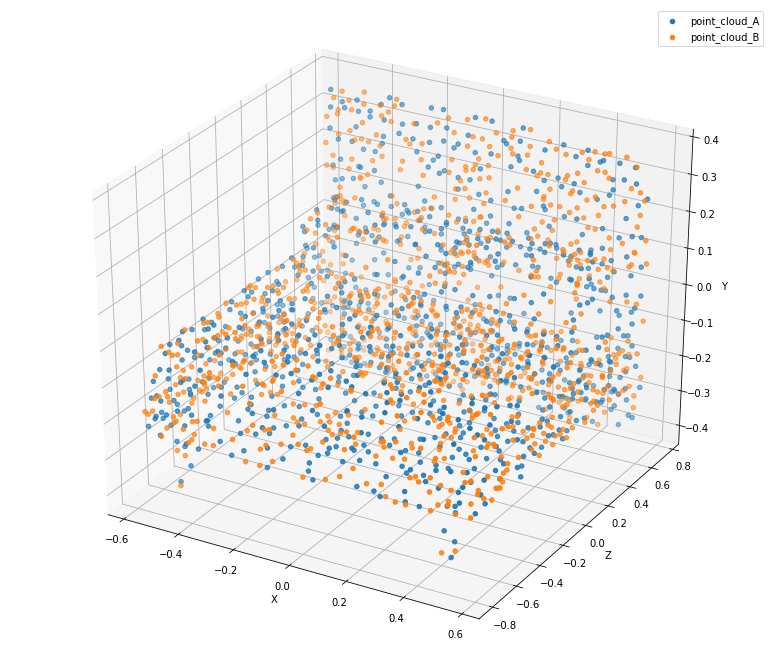

In [513]:
fig = plt.figure(figsize=(30,12))
ax = fig.add_subplot(1, 2, 1, projection='3d')
X = point_cloudA[:,0]
Y = point_cloudA[:,1]
Z = point_cloudA[:,2]
ax.scatter3D(X,Z,Y)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
X = point_cloudB[:,0]
Y = point_cloudB[:,1]
Z = point_cloudB[:,2]
ax.scatter3D(X,Z,Y)
ax.legend(['point_cloud_A','point_cloud_B'])
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
plt.show()

In [514]:
arrayDPDist, arrayAngulos = DPDist_vs_rotaciones(point_cloudA, point_cloudB, False,  False, True, 30)

0
INFO:tensorflow:Restoring parameters from ./model.ckpt


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


1
INFO:tensorflow:Restoring parameters from ./model.ckpt
2
INFO:tensorflow:Restoring parameters from ./model.ckpt
3
INFO:tensorflow:Restoring parameters from ./model.ckpt
4
INFO:tensorflow:Restoring parameters from ./model.ckpt
5
INFO:tensorflow:Restoring parameters from ./model.ckpt
6
INFO:tensorflow:Restoring parameters from ./model.ckpt
7
INFO:tensorflow:Restoring parameters from ./model.ckpt
8
INFO:tensorflow:Restoring parameters from ./model.ckpt
9
INFO:tensorflow:Restoring parameters from ./model.ckpt
10
INFO:tensorflow:Restoring parameters from ./model.ckpt
11
INFO:tensorflow:Restoring parameters from ./model.ckpt
12
INFO:tensorflow:Restoring parameters from ./model.ckpt
13
INFO:tensorflow:Restoring parameters from ./model.ckpt
14
INFO:tensorflow:Restoring parameters from ./model.ckpt
15
INFO:tensorflow:Restoring parameters from ./model.ckpt
16
INFO:tensorflow:Restoring parameters from ./model.ckpt
17
INFO:tensorflow:Restoring parameters from ./model.ckpt
18
INFO:tensorflow:Rest

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [515]:
arrayDPDist

array([0.0535, 0.0773, 0.132 , 0.2003, 0.263 , 0.311 , 0.3493, 0.3707,
       0.3728, 0.359 , 0.3223, 0.2804, 0.2407, 0.2087, 0.1855, 0.1727,
       0.1841, 0.2068, 0.2381, 0.2794, 0.3232, 0.3568, 0.3707, 0.3657,
       0.3458, 0.3084, 0.2602, 0.1996, 0.1324, 0.0812, 0.0535])

In [516]:
np.round(arrayAngulos,2)

array([ 6.28,  6.07,  5.86,  5.65,  5.45,  5.24,  5.03,  4.82,  4.61,
        4.4 ,  4.19,  3.98,  3.77,  3.56,  3.35,  3.14,  2.93,  2.72,
        2.51,  2.3 ,  2.09,  1.88,  1.68,  1.47,  1.26,  1.05,  0.84,
        0.63,  0.42,  0.21, -0.  ])

In [517]:
arrayDPDist = arrayDPDist/np.max(arrayDPDist)

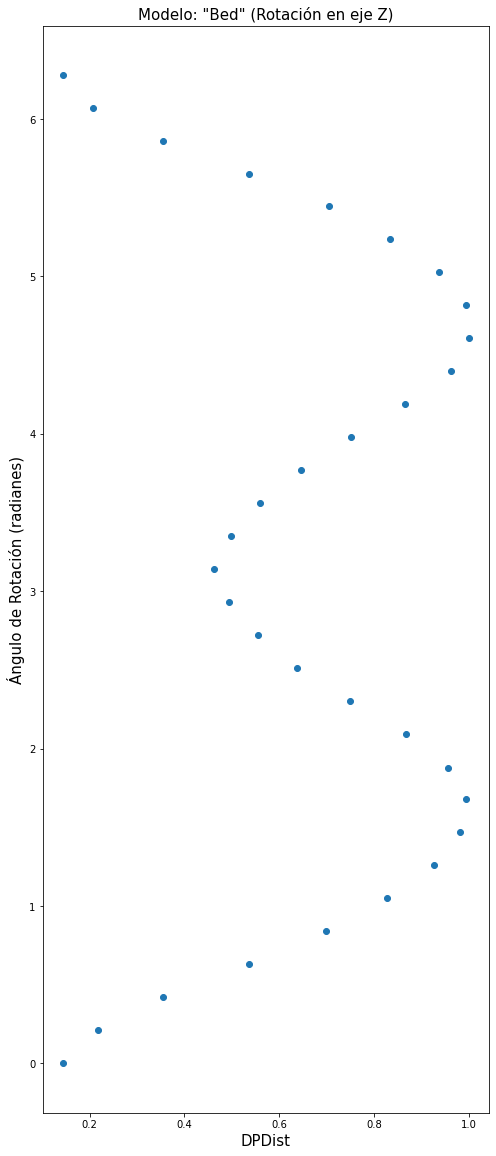

In [519]:
fig = plt.figure(figsize=(8,20))

ax = fig.add_subplot(1, 1, 1)
ax.scatter(arrayDPDist, np.round(arrayAngulos,2))
ax.set_title('Modelo: "Bed" (Rotación en eje Z)', size=15)
ax.set_xlabel('DPDist', size=15)  
ax.set_ylabel('Ángulo de Rotación (radianes)', size=15)
plt.show()

In [520]:
arrayAngulos[0]

6.283185307179586

In [521]:
ang_estimado_rad=AnguloDPDistMinimo(arrayDPDist, arrayAngulos)
print('Angulo estimado: ', ang_estimado_rad)

DPDist minimo:  0.14350858369098712
Angulo estimado:  6.283185307179586


In [522]:

Rm = Z_axis_rotation_matrix(ang_estimado_rad)   
registrada= np.dot(Rm, point_cloudB.T).T 


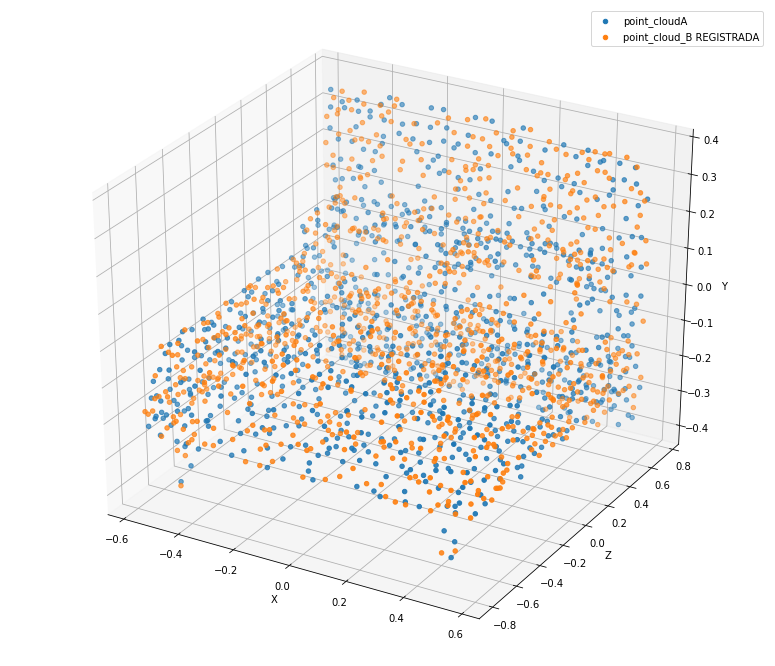

In [523]:
fig = plt.figure(figsize=(30,12))
ax = fig.add_subplot(1, 2, 1, projection='3d')
X = point_cloudA[:,0]
Y = point_cloudA[:,1]
Z = point_cloudA[:,2]
ax.scatter3D(X,Z,Y)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
X = registrada[:,0]
Y = registrada[:,1]
Z = registrada[:,2]
ax.scatter3D(X,Z,Y)
ax.legend(['point_cloudA','point_cloud_B REGISTRADA'])
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
plt.show()

#### Rotacion en y

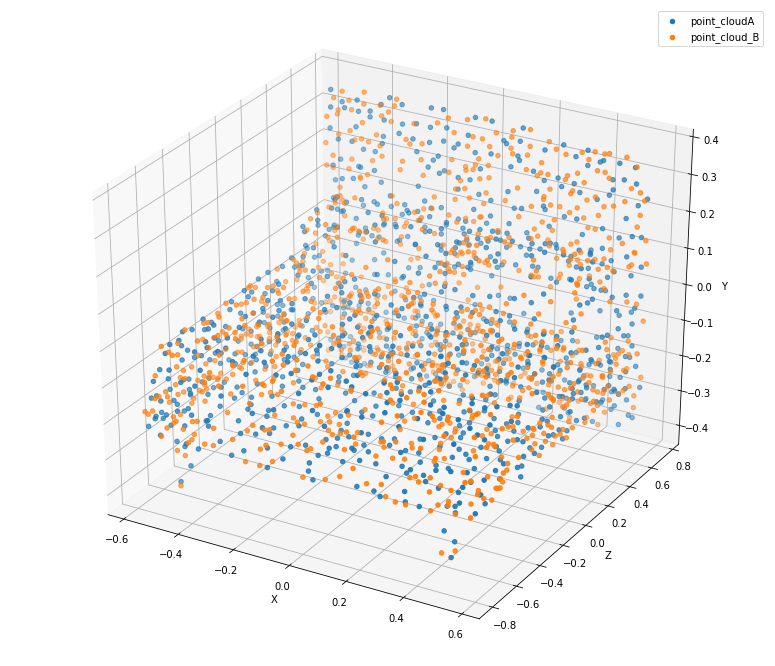

In [524]:
fig = plt.figure(figsize=(30,12))
ax = fig.add_subplot(1, 2, 1, projection='3d')
X = point_cloudA[:,0]
Y = point_cloudA[:,1]
Z = point_cloudA[:,2]
ax.scatter3D(X,Z,Y)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
X = point_cloudB[:,0]
Y = point_cloudB[:,1]
Z = point_cloudB[:,2]
ax.scatter3D(X,Z,Y)
ax.legend(['point_cloudA','point_cloud_B'])
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
plt.show()

In [525]:
arrayDPDist, arrayAngulos = DPDist_vs_rotaciones(point_cloudA, point_cloudB, False, True, False, 30)

INFO:tensorflow:Restoring parameters from ./model.ckpt


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tenso

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [526]:
arrayDPDist = arrayDPDist/np.max(arrayDPDist)

In [527]:
arrayDPDist

array([0.22990976, 0.35797164, 0.53975075, 0.66867211, 0.73571122,
       0.78341212, 0.84486463, 0.91920928, 0.95100988, 0.93510958,
       0.94112591, 0.95702621, 0.91792007, 0.83927804, 0.70047271,
       0.64030941, 0.70906747, 0.83669961, 0.93854749, 0.97421573,
       0.99871079, 0.99183498, 1.        , 0.95143962, 0.86162441,
       0.81435324, 0.79200688, 0.71293511, 0.54103997, 0.34980662,
       0.22990976])

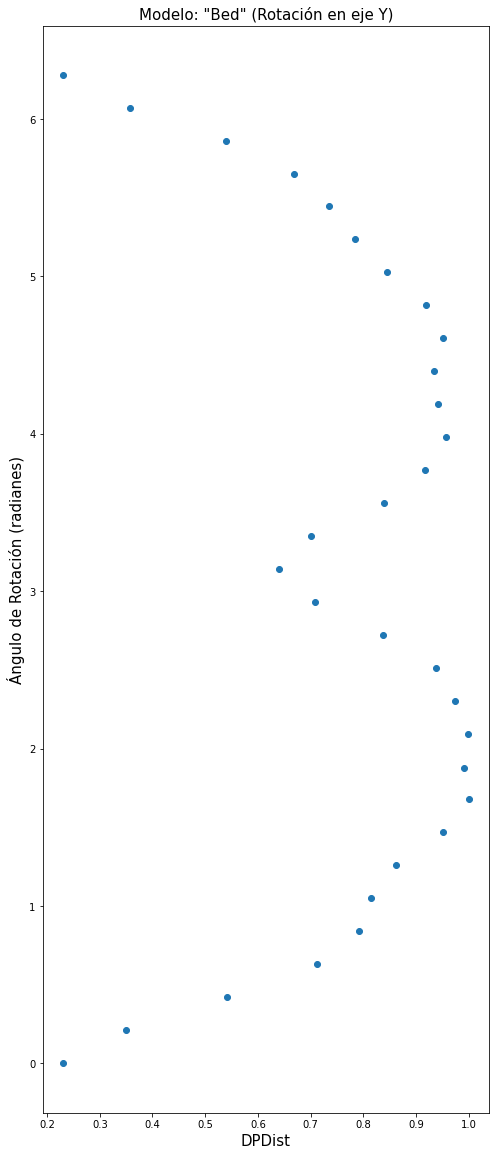

In [528]:
fig = plt.figure(figsize=(8,20))

ax = fig.add_subplot(1, 1, 1)
ax.scatter(arrayDPDist, np.round(arrayAngulos,2))
ax.set_title('Modelo: "Bed" (Rotación en eje Y)', size=15)
ax.set_xlabel('DPDist', size=15)  
ax.set_ylabel('Ángulo de Rotación (radianes)', size=15)
plt.show()

In [529]:

ang_estimado_rad=AnguloDPDistMinimo(arrayDPDist, arrayAngulos)
print('Angulo estimado: ', ang_estimado_rad)

DPDist minimo:  0.22990975504941985
Angulo estimado:  6.283185307179586


In [530]:

Rm = Y_axis_rotation_matrix(ang_estimado_rad)   
registrada= np.dot(Rm, point_cloudB.T).T 


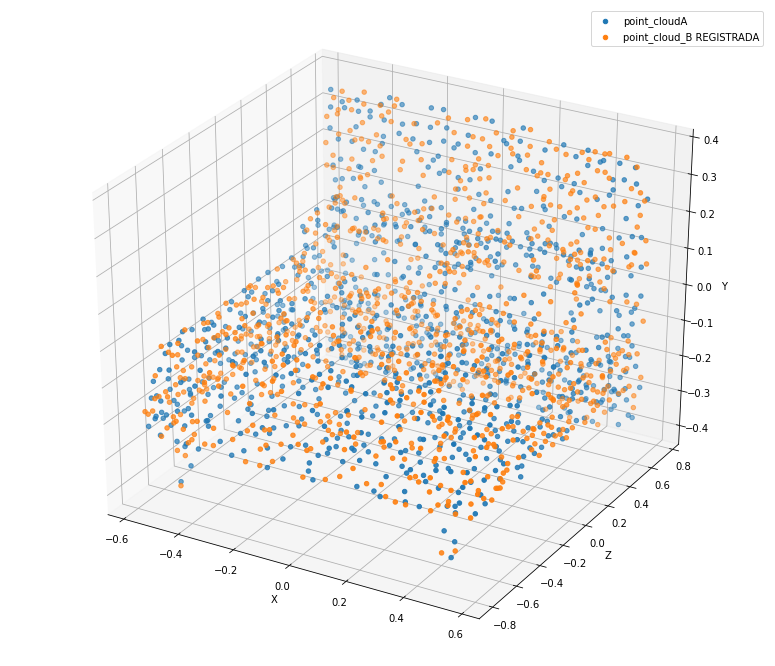

In [531]:
fig = plt.figure(figsize=(30,12))
ax = fig.add_subplot(1, 2, 1, projection='3d')
X = point_cloudA[:,0]
Y = point_cloudA[:,1]
Z = point_cloudA[:,2]
ax.scatter3D(X,Z,Y)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
X = registrada[:,0]
Y = registrada[:,1]
Z = registrada[:,2]
ax.scatter3D(X,Z,Y)
ax.legend(['point_cloudA','point_cloud_B REGISTRADA'])
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
plt.show()

#### Rotacion en x

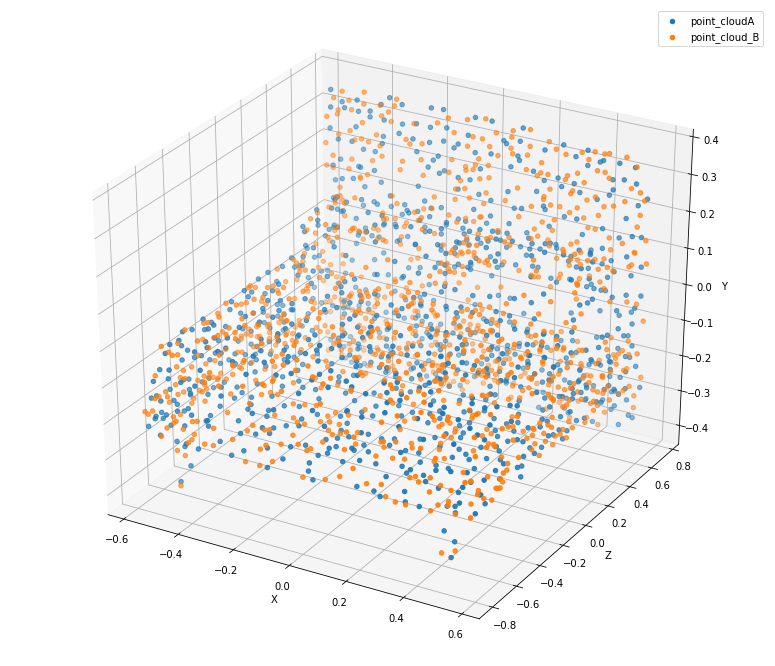

In [532]:
fig = plt.figure(figsize=(30,12))
ax = fig.add_subplot(1, 2, 1, projection='3d')
X = point_cloudA[:,0]
Y = point_cloudA[:,1]
Z = point_cloudA[:,2]
ax.scatter3D(X,Z,Y)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
X = point_cloudB[:,0]
Y = point_cloudB[:,1]
Z = point_cloudB[:,2]
ax.scatter3D(X,Z,Y)
ax.legend(['point_cloudA','point_cloud_B'])
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
plt.show()

In [533]:
arrayDPDist, arrayAngulos = DPDist_vs_rotaciones(point_cloudA, point_cloudB, True, False, False, 30)

INFO:tensorflow:Restoring parameters from ./model.ckpt


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tenso

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [534]:
arrayDPDist = arrayDPDist/np.max(arrayDPDist)

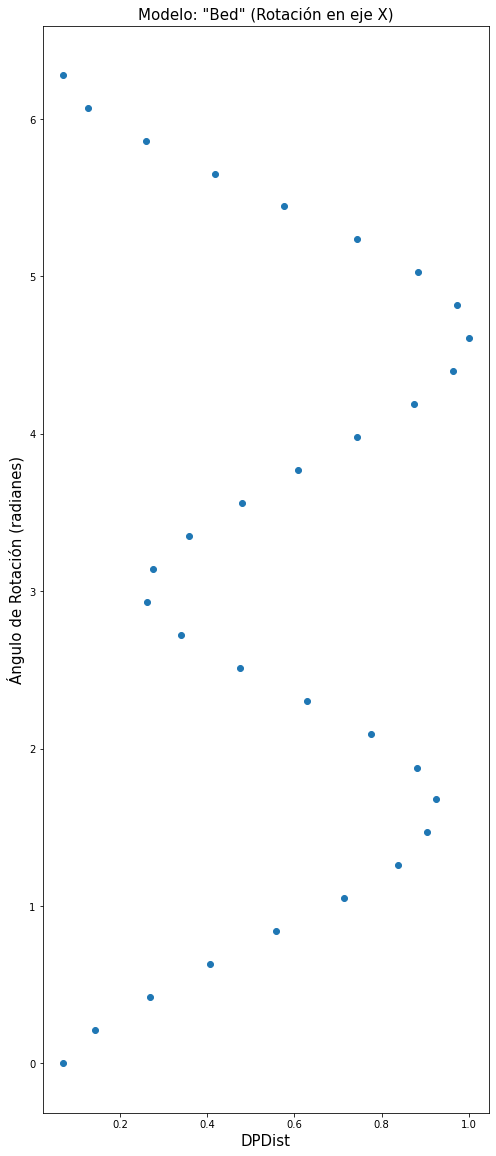

In [536]:
fig = plt.figure(figsize=(8,20))

ax = fig.add_subplot(1, 1, 1)
ax.scatter(arrayDPDist, np.round(arrayAngulos,2))
ax.set_title('Modelo: "Bed" (Rotación en eje X)', size=15)
ax.set_xlabel('DPDist', size=15)  
ax.set_ylabel('Ángulo de Rotación (radianes)', size=15)
plt.show()

In [506]:
ang_estimado_rad=AnguloDPDistMinimo(arrayDPDist, arrayAngulos)
print('Angulo estimado: ', ang_estimado_rad)

DPDist minimo:  0.12048404068747806
Angulo estimado:  6.283185307179586


In [507]:

Rm = rotation_matrix(ang_estimado_rad)   
registrada= np.dot(Rm, point_cloudB.T).T 


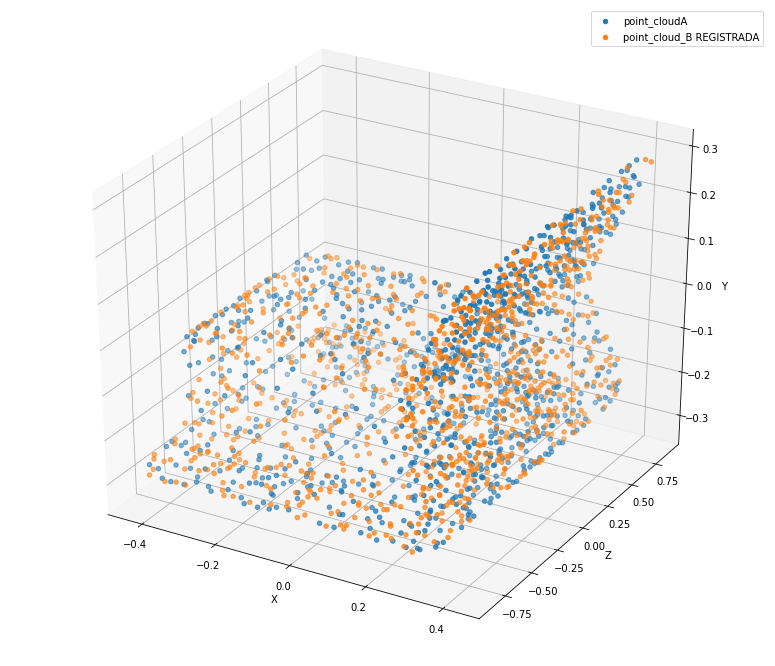

In [508]:
fig = plt.figure(figsize=(30,12))
ax = fig.add_subplot(1, 2, 1, projection='3d')
X = point_cloudA[:,0]
Y = point_cloudA[:,1]
Z = point_cloudA[:,2]
ax.scatter3D(X,Z,Y)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
X = registrada[:,0]
Y = registrada[:,1]
Z = registrada[:,2]
ax.scatter3D(X,Z,Y)
ax.legend(['point_cloudA','point_cloud_B REGISTRADA'])
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
plt.show()

#### Angulos de Rotacion inicial

In [417]:
import random

In [418]:
randXPcA = random.uniform(-np.pi*2, np.pi*2)
randXPcB = random.uniform(-np.pi*2, np.pi*2)
randYPcA = random.uniform(-np.pi*2, np.pi*2)
randYPcB = random.uniform(-np.pi*2, np.pi*2)
randZPcA = random.uniform(-np.pi*2, np.pi*2)
randZPcB = random.uniform(-np.pi*2, np.pi*2)

In [419]:
print('PCA:')
print('Angulo x: ', randXPcA ,' Angulo y: ', randYPcA , ' Angulo z: ',randZPcA )
print('_____________________________________________________________________________________________')
print('PCB:')
print('Angulo x: ', randXPcB ,' Angulo y: ', randYPcB , ' Angulo z: ',randZPcB )

PCA:
Angulo x:  -5.838183320705063  Angulo y:  -2.660132611367282  Angulo z:  -5.09285974391024
_____________________________________________________________________________________________
PCB:
Angulo x:  3.6588374013677196  Angulo y:  -0.2042997183824431  Angulo z:  -6.077094597178224


#### Rotación zyx

In [ ]:
point_cloudA, point_cloudB = generar_nubes_rotadas(chair[0],  True,  True, True, randXPcA, randYPcA, randZPcA, randXPcB, randYPcB, randZPcB, 'ZYX')

In [ ]:
point_cloudB = point_cloudB + 1

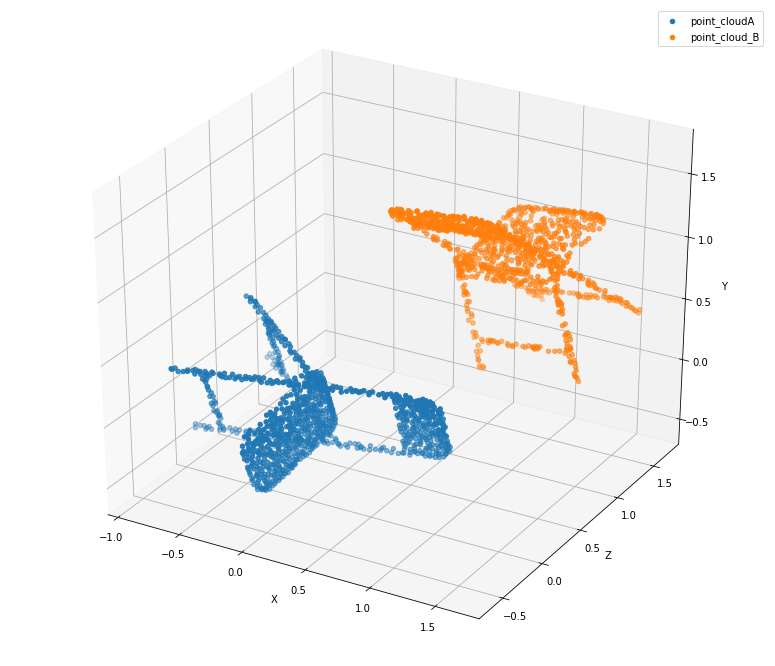

In [ ]:
fig = plt.figure(figsize=(30,12))
ax = fig.add_subplot(1, 2, 1, projection='3d')
X = point_cloudA[:,0]
Y = point_cloudA[:,1]
Z = point_cloudA[:,2]
ax.scatter3D(X,Z,Y)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
X = point_cloudB[:,0]
Y = point_cloudB[:,1]
Z = point_cloudB[:,2]
ax.scatter3D(X,Z,Y)
ax.legend(['point_cloudA','point_cloud_B'])
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
plt.show()

##### Rotacion en z (por separado)

In [ ]:
arrayDPDist, arrayAngulos = DPDist_vs_rotaciones(point_cloudA, point_cloudB, False, False, True, 20)

INFO:tensorflow:Restoring parameters from ./model.ckpt


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tenso

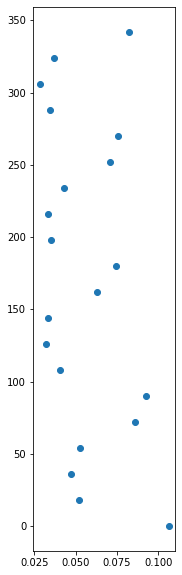

In [ ]:
fig = plt.figure(figsize=(30,10))
for i in range(len(arrayDPDist)):
  ax = fig.add_subplot(1, 10,1+i)
  ax.scatter(arrayDPDist, arrayAngulos)
plt.show()

In [ ]:
ang_estimado_rad=AnguloDPDistMinimo(arrayDPDist, arrayAngulos)
print('Angulo estimado: ', ang_estimado_rad)

DPDist minimo:  0.0282
Angulo estimado:  5.340707511102648


In [ ]:
np.mean(arrayDPDist)

0.055999999999999994

##### Rotacion en y (por separado)

In [ ]:
arrayDPDist, arrayAngulos = DPDist_vs_rotaciones(point_cloudA, point_cloudB, False, True, False, 20)

INFO:tensorflow:Restoring parameters from ./model.ckpt


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tenso

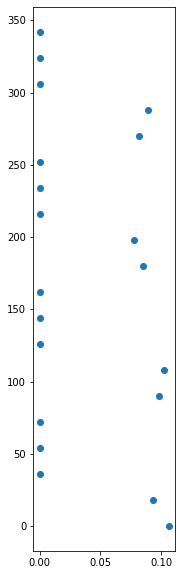

In [ ]:
fig = plt.figure(figsize=(30,10))
for i in range(len(arrayDPDist)):
  ax = fig.add_subplot(1, 10,1+i)
  ax.scatter(arrayDPDist, arrayAngulos)
plt.show()

In [ ]:
ang_estimado_rad=AnguloDPDistMinimo(arrayDPDist, arrayAngulos)
print('Angulo estimado: ', ang_estimado_rad)

DPDist minimo:  0.0
Angulo estimado:  5.969026041820607


In [ ]:
np.mean(arrayDPDist)

0.036750000000000005

##### Rotacion en x (por separado)

In [ ]:
arrayDPDist, arrayAngulos = DPDist_vs_rotaciones(point_cloudA, point_cloudB, True, False, False, 20)

INFO:tensorflow:Restoring parameters from ./model.ckpt


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tenso

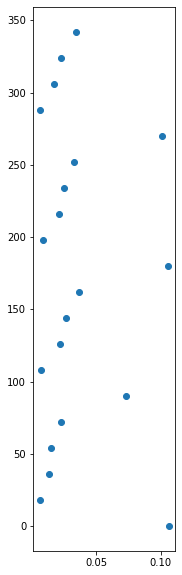

In [ ]:
fig = plt.figure(figsize=(30,10))
for i in range(len(arrayDPDist)):
  ax = fig.add_subplot(1, 10,1+i)
  ax.scatter(arrayDPDist, arrayAngulos)
plt.show()

In [ ]:
ang_estimado_rad=AnguloDPDistMinimo(arrayDPDist, arrayAngulos)
print('Angulo estimado: ', ang_estimado_rad)

DPDist minimo:  0.0058
Angulo estimado:  0.3141592653589793


In [ ]:
np.mean(arrayDPDist)

0.034905

#### Rotación zxy

In [ ]:
point_cloudA, point_cloudB = generar_nubes_rotadas(chair[0],  True,  True, True, randXPcA, randYPcA, randZPcA, randXPcB, randYPcB, randZPcB, 'ZXY')

In [ ]:
point_cloudB = point_cloudB + 1

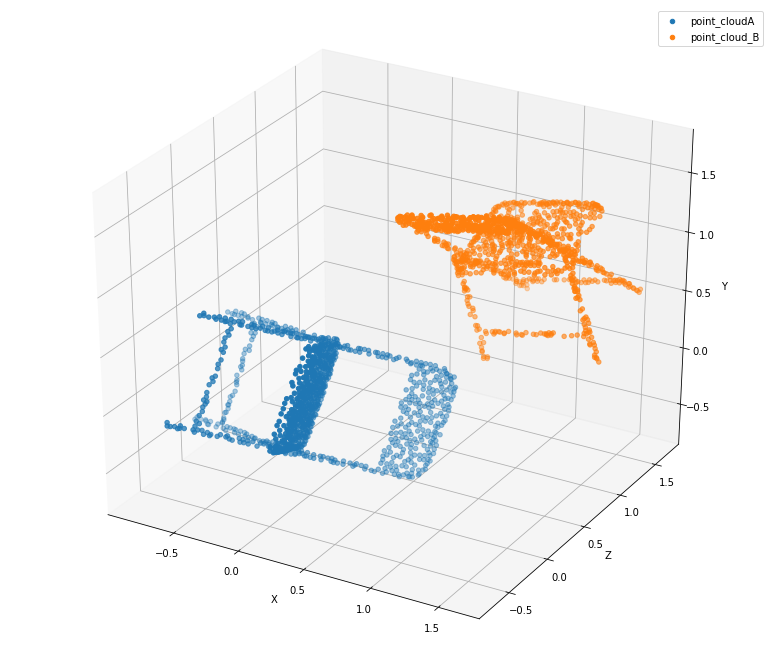

In [ ]:
fig = plt.figure(figsize=(30,12))
ax = fig.add_subplot(1, 2, 1, projection='3d')
X = point_cloudA[:,0]
Y = point_cloudA[:,1]
Z = point_cloudA[:,2]
ax.scatter3D(X,Z,Y)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
X = point_cloudB[:,0]
Y = point_cloudB[:,1]
Z = point_cloudB[:,2]
ax.scatter3D(X,Z,Y)
ax.legend(['point_cloudA','point_cloud_B'])
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
plt.show()

##### Rotacion en z (por separado)

In [ ]:
arrayDPDist, arrayAngulos = DPDist_vs_rotaciones(point_cloudA, point_cloudB, False, False, True, 20)

INFO:tensorflow:Restoring parameters from ./model.ckpt


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tenso

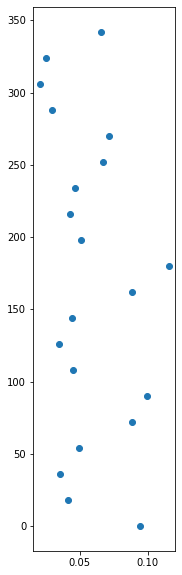

In [ ]:
fig = plt.figure(figsize=(30,10))
for i in range(len(arrayDPDist)):
  ax = fig.add_subplot(1, 10,1+i)
  ax.scatter(arrayDPDist, arrayAngulos)
plt.show()

In [ ]:
ang_estimado_rad=AnguloDPDistMinimo(arrayDPDist, arrayAngulos)
print('Angulo estimado: ', ang_estimado_rad)

DPDist minimo:  0.0206
Angulo estimado:  5.340707511102648


In [ ]:
np.mean(arrayDPDist)

0.05777000000000001

##### Rotacion en y (por separado)

In [ ]:
arrayDPDist, arrayAngulos = DPDist_vs_rotaciones(point_cloudA, point_cloudB, False, True, False, 20)

INFO:tensorflow:Restoring parameters from ./model.ckpt


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tenso

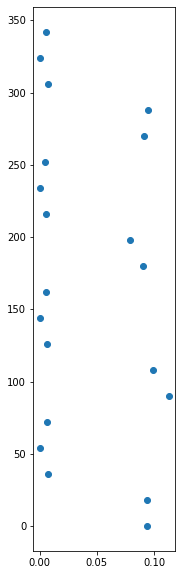

In [ ]:
fig = plt.figure(figsize=(30,10))
for i in range(len(arrayDPDist)):
  ax = fig.add_subplot(1, 10,1+i)
  ax.scatter(arrayDPDist, arrayAngulos)
plt.show()

In [ ]:
ang_estimado_rad=AnguloDPDistMinimo(arrayDPDist, arrayAngulos)
print('Angulo estimado: ', ang_estimado_rad)

DPDist minimo:  0.0
Angulo estimado:  5.654866776461628


In [ ]:
np.mean(arrayDPDist)

0.04012

##### Rotacion en x (por separado)

In [ ]:
arrayDPDist, arrayAngulos = DPDist_vs_rotaciones(point_cloudA, point_cloudB, True, False, False, 20)

INFO:tensorflow:Restoring parameters from ./model.ckpt


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tenso

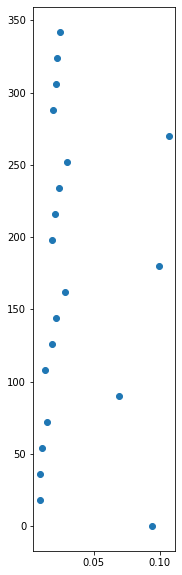

In [ ]:
fig = plt.figure(figsize=(30,10))
for i in range(len(arrayDPDist)):
  ax = fig.add_subplot(1, 10,1+i)
  ax.scatter(arrayDPDist, arrayAngulos)
plt.show()

In [ ]:
ang_estimado_rad=AnguloDPDistMinimo(arrayDPDist, arrayAngulos)
print('Angulo estimado: ', ang_estimado_rad)

DPDist minimo:  0.009
Angulo estimado:  0.3141592653589793


In [ ]:
np.mean(arrayDPDist)

0.03358

#### Rotación yzx

In [ ]:
point_cloudA, point_cloudB = generar_nubes_rotadas(chair[0],  True,  True, True, randXPcA, randYPcA, randZPcA, randXPcB, randYPcB, randZPcB, 'YZX')

In [ ]:
point_cloudB = point_cloudB + 1

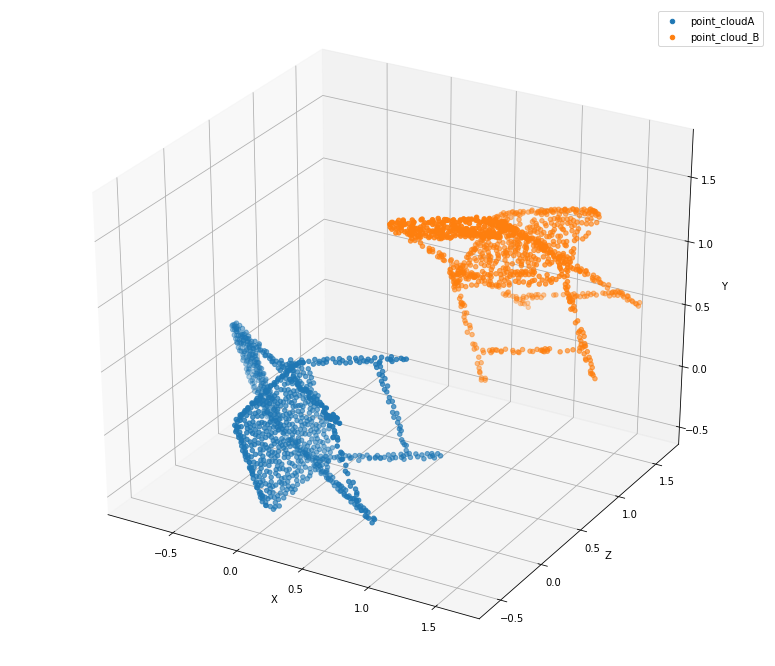

In [ ]:
fig = plt.figure(figsize=(30,12))
ax = fig.add_subplot(1, 2, 1, projection='3d')
X = point_cloudA[:,0]
Y = point_cloudA[:,1]
Z = point_cloudA[:,2]
ax.scatter3D(X,Z,Y)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
X = point_cloudB[:,0]
Y = point_cloudB[:,1]
Z = point_cloudB[:,2]
ax.scatter3D(X,Z,Y)
ax.legend(['point_cloudA','point_cloud_B'])
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
plt.show()

##### Rotacion en z (por separado)

In [ ]:
arrayDPDist, arrayAngulos = DPDist_vs_rotaciones(point_cloudA, point_cloudB, False, False, True, 20)

INFO:tensorflow:Restoring parameters from ./model.ckpt


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tenso

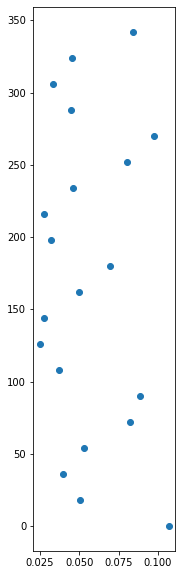

In [ ]:
fig = plt.figure(figsize=(30,10))
for i in range(len(arrayDPDist)):
  ax = fig.add_subplot(1, 10,1+i)
  ax.scatter(arrayDPDist, arrayAngulos)
plt.show()

In [ ]:
ang_estimado_rad=AnguloDPDistMinimo(arrayDPDist, arrayAngulos)
print('Angulo estimado: ', ang_estimado_rad)

DPDist minimo:  0.0248
Angulo estimado:  2.199114857512855


In [ ]:
np.mean(arrayDPDist)

0.056025000000000005

##### Rotacion en y (por separado)

In [ ]:
arrayDPDist, arrayAngulos = DPDist_vs_rotaciones(point_cloudA, point_cloudB, False, True, False, 20)

INFO:tensorflow:Restoring parameters from ./model.ckpt


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tenso

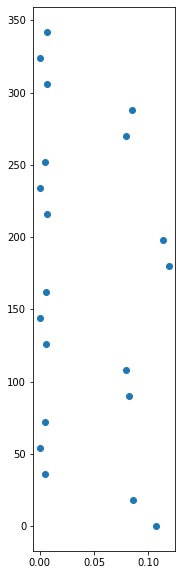

In [ ]:
fig = plt.figure(figsize=(30,10))
for i in range(len(arrayDPDist)):
  ax = fig.add_subplot(1, 10,1+i)
  ax.scatter(arrayDPDist, arrayAngulos)
plt.show()

In [ ]:
ang_estimado_rad=AnguloDPDistMinimo(arrayDPDist, arrayAngulos)
print('Angulo estimado: ', ang_estimado_rad)

DPDist minimo:  0.0
Angulo estimado:  5.654866776461628


In [ ]:
np.mean(arrayDPDist)

0.039925

##### Rotacion en x (por separado)

In [ ]:
arrayDPDist, arrayAngulos = DPDist_vs_rotaciones(point_cloudA, point_cloudB, True, False, False, 20)

INFO:tensorflow:Restoring parameters from ./model.ckpt


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tenso

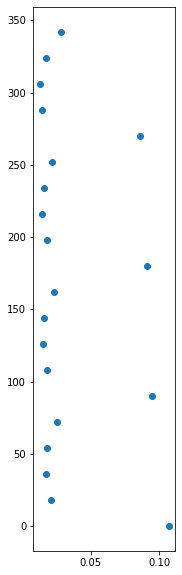

In [ ]:
fig = plt.figure(figsize=(30,10))
for i in range(len(arrayDPDist)):
  ax = fig.add_subplot(1, 10,1+i)
  ax.scatter(arrayDPDist, arrayAngulos)
plt.show()

In [ ]:
ang_estimado_rad=AnguloDPDistMinimo(arrayDPDist, arrayAngulos)
print('Angulo estimado: ', ang_estimado_rad)

DPDist minimo:  0.0126
Angulo estimado:  5.340707511102648


In [ ]:
np.mean(arrayDPDist)

0.033735

#### Rotación yxz

In [ ]:
point_cloudA, point_cloudB = generar_nubes_rotadas(chair[0],  True,  True, True, randXPcA, randYPcA, randZPcA, randXPcB, randYPcB, randZPcB, 'YXZ')

In [ ]:
point_cloudB = point_cloudB + 1

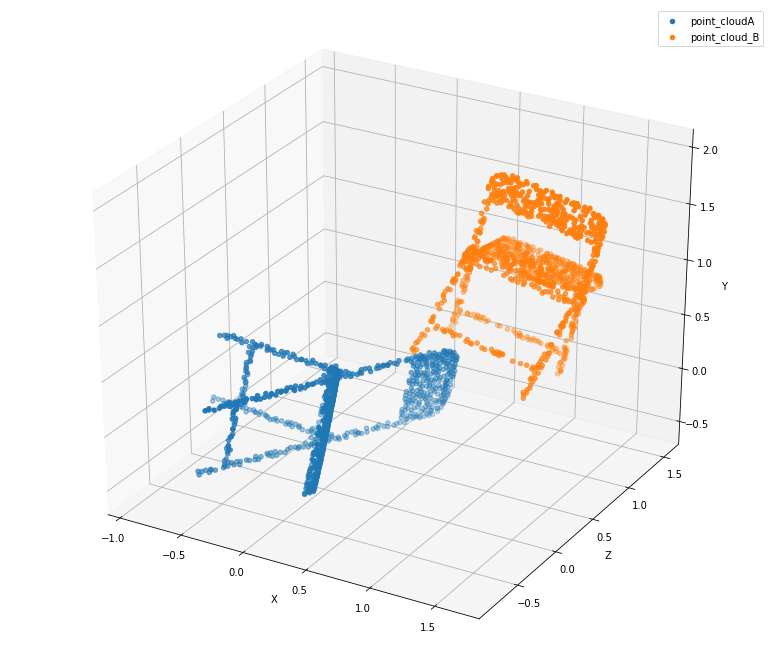

In [ ]:
fig = plt.figure(figsize=(30,12))
ax = fig.add_subplot(1, 2, 1, projection='3d')
X = point_cloudA[:,0]
Y = point_cloudA[:,1]
Z = point_cloudA[:,2]
ax.scatter3D(X,Z,Y)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
X = point_cloudB[:,0]
Y = point_cloudB[:,1]
Z = point_cloudB[:,2]
ax.scatter3D(X,Z,Y)
ax.legend(['point_cloudA','point_cloud_B'])
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
plt.show()

##### Rotacion en z (por separado)

In [ ]:
arrayDPDist, arrayAngulos = DPDist_vs_rotaciones(point_cloudA, point_cloudB, False, False, True, 20)

INFO:tensorflow:Restoring parameters from ./model.ckpt


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tenso

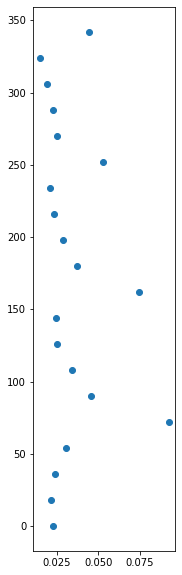

In [ ]:
fig = plt.figure(figsize=(30,10))
for i in range(len(arrayDPDist)):
  ax = fig.add_subplot(1, 10,1+i)
  ax.scatter(arrayDPDist, arrayAngulos)
plt.show()

In [ ]:
ang_estimado_rad=AnguloDPDistMinimo(arrayDPDist, arrayAngulos)
print('Angulo estimado: ', ang_estimado_rad)

DPDist minimo:  0.0146
Angulo estimado:  5.654866776461628


In [ ]:
np.mean(arrayDPDist)

0.03415499999999999

##### Rotacion en y (por separado)

In [ ]:
arrayDPDist, arrayAngulos = DPDist_vs_rotaciones(point_cloudA, point_cloudB, False, True, False, 20)

INFO:tensorflow:Restoring parameters from ./model.ckpt


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tenso

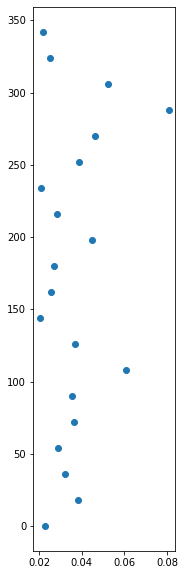

In [ ]:
fig = plt.figure(figsize=(30,10))
for i in range(len(arrayDPDist)):
  ax = fig.add_subplot(1, 10,1+i)
  ax.scatter(arrayDPDist, arrayAngulos)
plt.show()

In [ ]:
ang_estimado_rad=AnguloDPDistMinimo(arrayDPDist, arrayAngulos)
print('Angulo estimado: ', ang_estimado_rad)

DPDist minimo:  0.0202
Angulo estimado:  2.5132741228718345


In [ ]:
np.mean(arrayDPDist)

0.036105

##### Rotacion en x (por separado)

In [ ]:
arrayDPDist, arrayAngulos = DPDist_vs_rotaciones(point_cloudA, point_cloudB, True, False, False, 20)

INFO:tensorflow:Restoring parameters from ./model.ckpt


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tenso

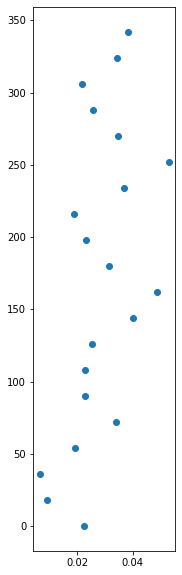

In [ ]:
fig = plt.figure(figsize=(30,10))
for i in range(len(arrayDPDist)):
  ax = fig.add_subplot(1, 10,1+i)
  ax.scatter(arrayDPDist, arrayAngulos)
plt.show()

In [ ]:
ang_estimado_rad=AnguloDPDistMinimo(arrayDPDist, arrayAngulos)
print('Angulo estimado: ', ang_estimado_rad)

DPDist minimo:  0.0063
Angulo estimado:  0.6283185307179586


In [ ]:
np.mean(arrayDPDist)

0.028425

#### Rotación xzy

In [ ]:
point_cloudA, point_cloudB = generar_nubes_rotadas(chair[0],  True,  True, True, randXPcA, randYPcA, randZPcA, randXPcB, randYPcB, randZPcB, 'XZY')

In [ ]:
point_cloudB = point_cloudB + 1

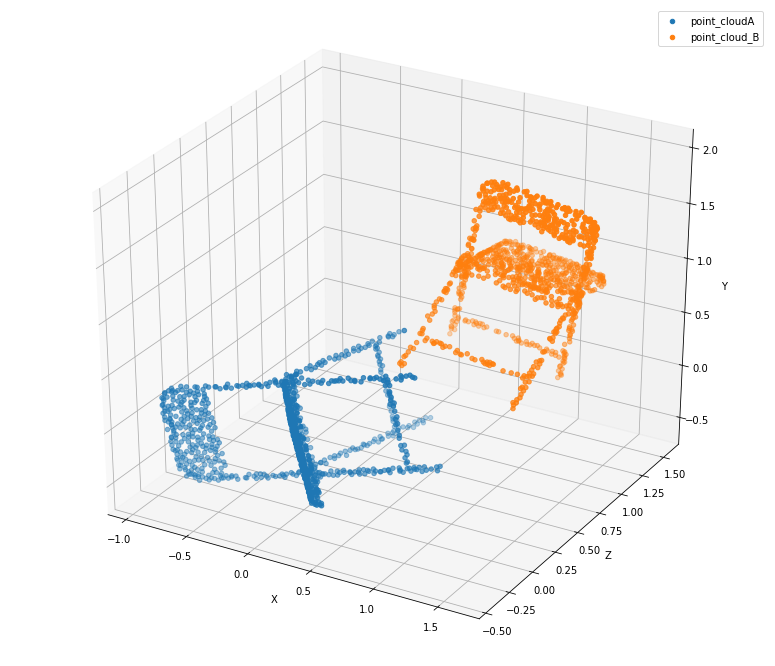

In [ ]:
fig = plt.figure(figsize=(30,12))
ax = fig.add_subplot(1, 2, 1, projection='3d')
X = point_cloudA[:,0]
Y = point_cloudA[:,1]
Z = point_cloudA[:,2]
ax.scatter3D(X,Z,Y)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
X = point_cloudB[:,0]
Y = point_cloudB[:,1]
Z = point_cloudB[:,2]
ax.scatter3D(X,Z,Y)
ax.legend(['point_cloudA','point_cloud_B'])
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
plt.show()

##### Rotacion en z (por separado)

In [ ]:
arrayDPDist, arrayAngulos = DPDist_vs_rotaciones(point_cloudA, point_cloudB, False, False, True, 20)

INFO:tensorflow:Restoring parameters from ./model.ckpt


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tenso

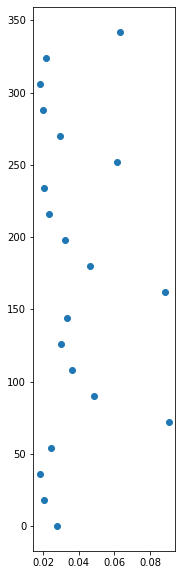

In [ ]:
fig = plt.figure(figsize=(30,10))
for i in range(len(arrayDPDist)):
  ax = fig.add_subplot(1, 10,1+i)
  ax.scatter(arrayDPDist, arrayAngulos)
plt.show()

In [ ]:
ang_estimado_rad=AnguloDPDistMinimo(arrayDPDist, arrayAngulos)
print('Angulo estimado: ', ang_estimado_rad)

DPDist minimo:  0.0181
Angulo estimado:  5.340707511102648


In [ ]:
np.mean(arrayDPDist)

0.037665

##### Rotacion en y (por separado)

In [ ]:
arrayDPDist, arrayAngulos = DPDist_vs_rotaciones(point_cloudA, point_cloudB, False, True, False, 20)

INFO:tensorflow:Restoring parameters from ./model.ckpt


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tenso

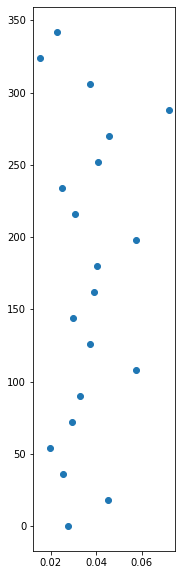

In [ ]:
fig = plt.figure(figsize=(30,10))
for i in range(len(arrayDPDist)):
  ax = fig.add_subplot(1, 10,1+i)
  ax.scatter(arrayDPDist, arrayAngulos)
plt.show()

In [ ]:
ang_estimado_rad=AnguloDPDistMinimo(arrayDPDist, arrayAngulos)
print('Angulo estimado: ', ang_estimado_rad)

DPDist minimo:  0.0152
Angulo estimado:  5.654866776461628


In [ ]:
np.mean(arrayDPDist)

0.03651

##### Rotacion en x (por separado)

In [ ]:
arrayDPDist, arrayAngulos = DPDist_vs_rotaciones(point_cloudA, point_cloudB, True, False, False, 20)

INFO:tensorflow:Restoring parameters from ./model.ckpt


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tenso

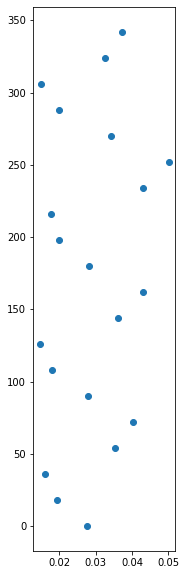

In [ ]:
fig = plt.figure(figsize=(30,10))
for i in range(len(arrayDPDist)):
  ax = fig.add_subplot(1, 10,1+i)
  ax.scatter(arrayDPDist, arrayAngulos)
plt.show()

In [ ]:
ang_estimado_rad=AnguloDPDistMinimo(arrayDPDist, arrayAngulos)
print('Angulo estimado: ', ang_estimado_rad)

DPDist minimo:  0.0146
Angulo estimado:  2.199114857512855


In [ ]:
np.mean(arrayDPDist)

0.028814999999999997

#### Rotación xyz

In [ ]:
point_cloudA, point_cloudB = generar_nubes_rotadas(chair[0],  True,  True, True, randXPcA, randYPcA, randZPcA, randXPcB, randYPcB, randZPcB, 'XYZ')

In [ ]:
point_cloudB = point_cloudB + 1

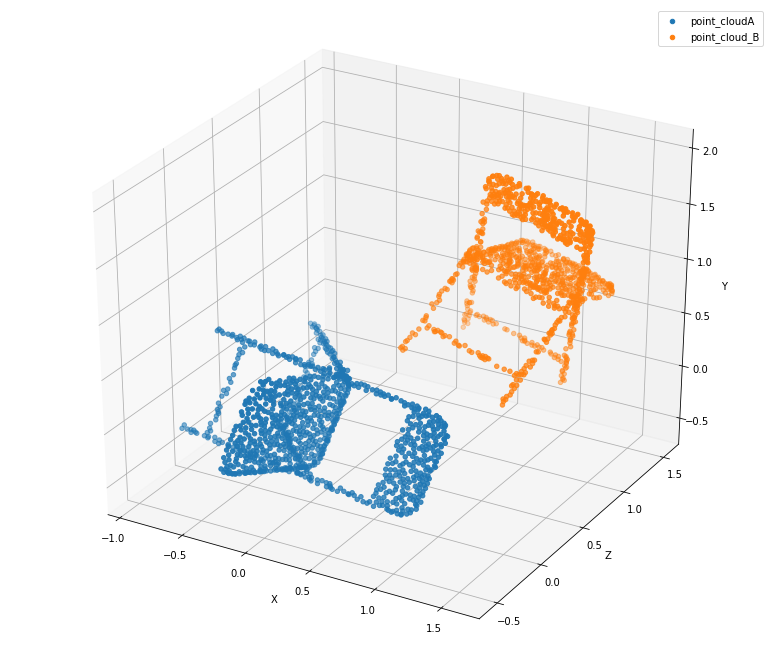

In [ ]:
fig = plt.figure(figsize=(30,12))
ax = fig.add_subplot(1, 2, 1, projection='3d')
X = point_cloudA[:,0]
Y = point_cloudA[:,1]
Z = point_cloudA[:,2]
ax.scatter3D(X,Z,Y)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
X = point_cloudB[:,0]
Y = point_cloudB[:,1]
Z = point_cloudB[:,2]
ax.scatter3D(X,Z,Y)
ax.legend(['point_cloudA','point_cloud_B'])
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
plt.show()

##### Rotacion en z (por separado)

In [ ]:
arrayDPDist, arrayAngulos = DPDist_vs_rotaciones(point_cloudA, point_cloudB, False, False, True, 20)

INFO:tensorflow:Restoring parameters from ./model.ckpt


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tenso

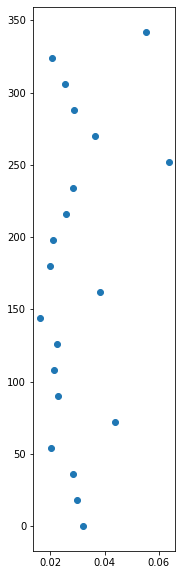

In [ ]:
fig = plt.figure(figsize=(30,10))
for i in range(len(arrayDPDist)):
  ax = fig.add_subplot(1, 10,1+i)
  ax.scatter(arrayDPDist, arrayAngulos)
plt.show()

In [ ]:
ang_estimado_rad=AnguloDPDistMinimo(arrayDPDist, arrayAngulos)
print('Angulo estimado: ', ang_estimado_rad)

DPDist minimo:  0.0161
Angulo estimado:  2.5132741228718345


In [ ]:
np.mean(arrayDPDist)

0.030045

##### Rotacion en y (por separado)

In [ ]:
arrayDPDist, arrayAngulos = DPDist_vs_rotaciones(point_cloudA, point_cloudB, False, True, False, 20)

INFO:tensorflow:Restoring parameters from ./model.ckpt


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tenso

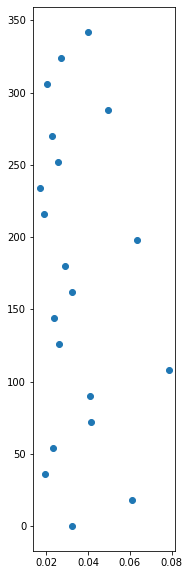

In [ ]:
fig = plt.figure(figsize=(30,10))
for i in range(len(arrayDPDist)):
  ax = fig.add_subplot(1, 10,1+i)
  ax.scatter(arrayDPDist, arrayAngulos)
plt.show()

In [ ]:
ang_estimado_rad=AnguloDPDistMinimo(arrayDPDist, arrayAngulos)
print('Angulo estimado: ', ang_estimado_rad)

DPDist minimo:  0.017
Angulo estimado:  4.084070449666731


In [ ]:
np.mean(arrayDPDist)

0.034730000000000004

##### Rotacion en x (por separado)

In [ ]:
arrayDPDist, arrayAngulos = DPDist_vs_rotaciones(point_cloudA, point_cloudB, True, False, False, 20)

INFO:tensorflow:Restoring parameters from ./model.ckpt


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tenso

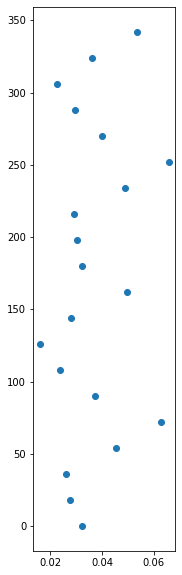

In [ ]:
fig = plt.figure(figsize=(30,10))
for i in range(len(arrayDPDist)):
  ax = fig.add_subplot(1, 10,1+i)
  ax.scatter(arrayDPDist, arrayAngulos)
plt.show()

In [ ]:
ang_estimado_rad=AnguloDPDistMinimo(arrayDPDist, arrayAngulos)
print('Angulo estimado: ', ang_estimado_rad)

DPDist minimo:  0.0159
Angulo estimado:  2.199114857512855


In [ ]:
np.mean(arrayDPDist)

0.036895

### Pruebas matrices DPDist

#### Nubes "registradas"

In [ ]:
point_cloudA, point_cloudB = generar_nubes_rotadas(chair[0],  False,  False, True, 0, 0, np.pi, 0, 0, np.pi, 'None')

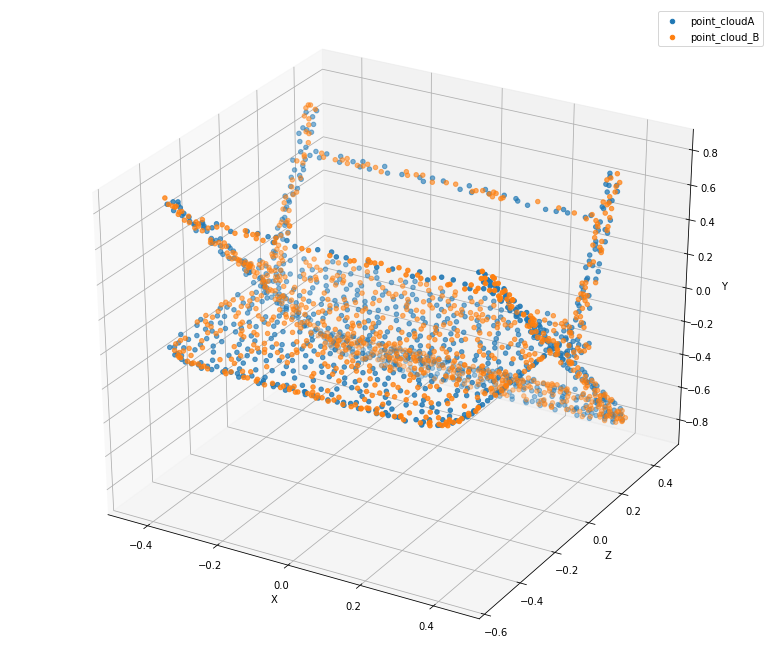

In [ ]:
fig = plt.figure(figsize=(30,12))
ax = fig.add_subplot(1, 2, 1, projection='3d')
X = point_cloudA[:,0]
Y = point_cloudA[:,1]
Z = point_cloudA[:,2]
ax.scatter3D(X,Z,Y)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
X = point_cloudB[:,0]
Y = point_cloudB[:,1]
Z = point_cloudB[:,2]
ax.scatter3D(X,Z,Y)
ax.legend(['point_cloudA','point_cloud_B'])
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
plt.show()


In [ ]:
distAB, distBA = DPDIST(point_cloudA, point_cloudB) 

INFO:tensorflow:Restoring parameters from ./model.ckpt


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
distAB, distAB,  DistPC_PC = DPDISTnormaAndDistPc_Pc(distAB, distBA)

In [ ]:
distAB = distAB/np.max(distAB)

In [ ]:
M = distAB.reshape(32,32)

In [ ]:
M2 = np.ones((1024,1024))
np.fill_diagonal(M2, distAB)

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


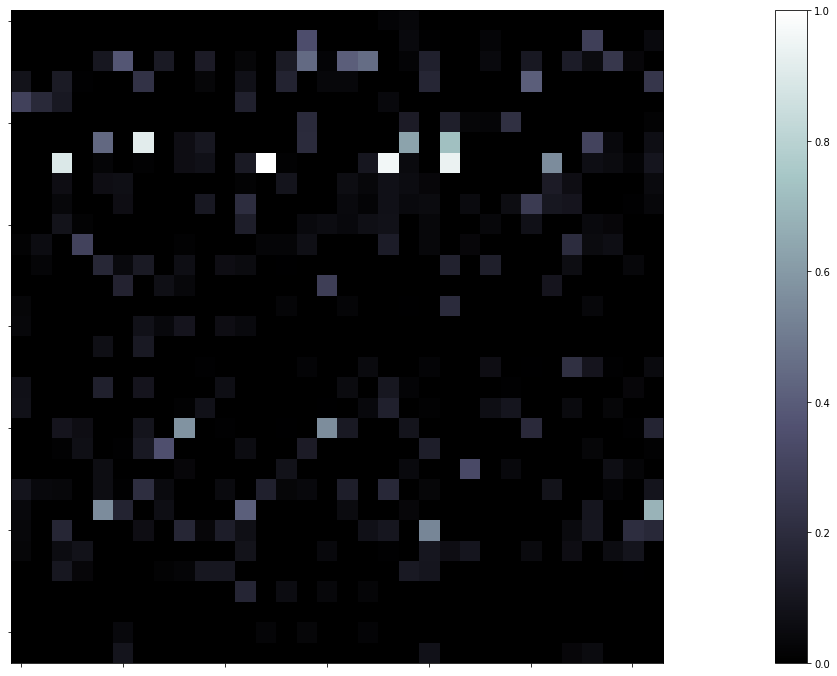

In [ ]:
fig = plt.figure(figsize=(40,12))

ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.imshow(M, cmap=plt.cm.bone, vmin=0, vmax=1)
ax.set_xticklabels([np.arange(0, 2*np.pi)])
ax.set_yticklabels([np.arange(0, 2*np.pi)])
plt.colorbar()


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


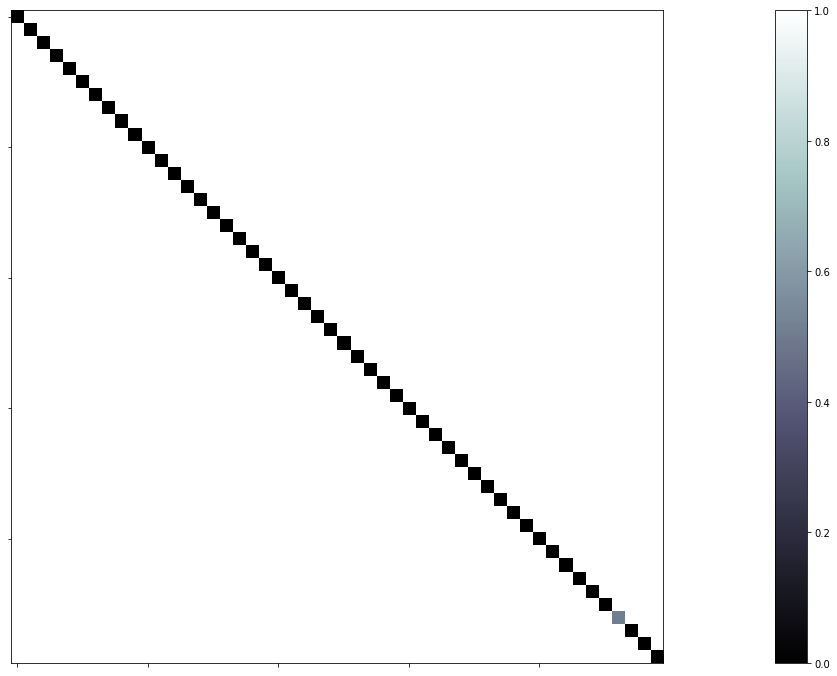

In [ ]:
fig = plt.figure(figsize=(40,12))

ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.imshow(M2[0:50,0:50], cmap=plt.cm.bone, vmin=0, vmax=1)
ax.set_xticklabels([np.arange(0, 2*np.pi)])
ax.set_yticklabels([np.arange(0, 2*np.pi)])
plt.colorbar()


####Nubes "sin registrar"

In [ ]:
point_cloudA, point_cloudB = generar_nubes_rotadas(chair[0],  True,  True, True, 0, np.pi, -1.8, 0, 1.8, np.pi, 'XYZ')

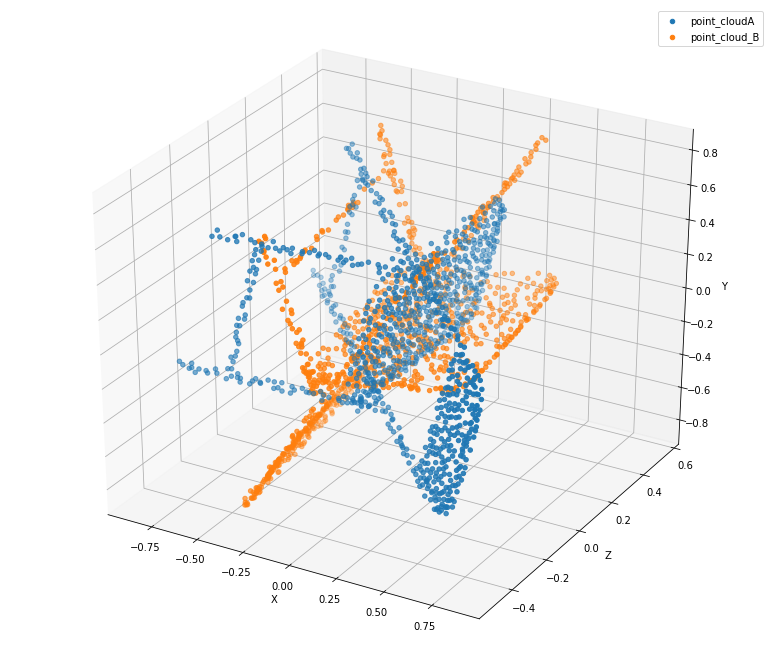

In [ ]:
fig = plt.figure(figsize=(30,12))
ax = fig.add_subplot(1, 2, 1, projection='3d')
X = point_cloudA[:,0]
Y = point_cloudA[:,1]
Z = point_cloudA[:,2]
ax.scatter3D(X,Z,Y)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
X = point_cloudB[:,0]
Y = point_cloudB[:,1]
Z = point_cloudB[:,2]
ax.scatter3D(X,Z,Y)
ax.legend(['point_cloudA','point_cloud_B'])
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
plt.show()

In [ ]:
distAB, distBA = DPDIST(point_cloudA, point_cloudB) 

INFO:tensorflow:Restoring parameters from ./model.ckpt


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
distAB, distBA, DistPC_PC = DPDISTnormaAndDistPc_Pc(distAB, distBA)

In [ ]:
distAB = distAB/np.max(distAB)

In [ ]:
M = distAB.reshape(32,32)

In [ ]:
M2 = np.ones((1024,1024))
np.fill_diagonal(M2, distAB)

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


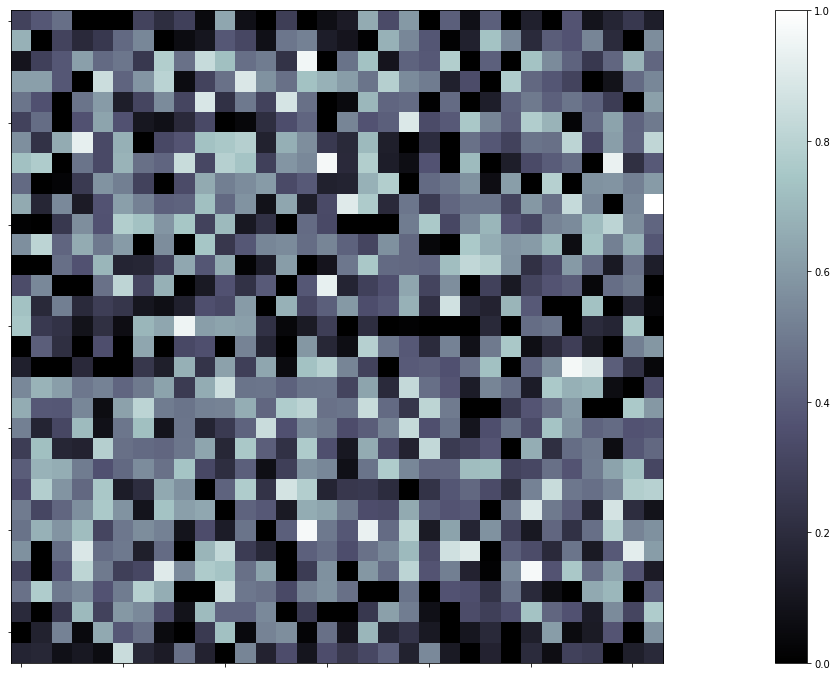

In [ ]:
fig = plt.figure(figsize=(40,12))

ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.imshow(M, cmap=plt.cm.bone, vmin=0, vmax=1)
ax.set_xticklabels([np.arange(0, 2*np.pi)])
ax.set_yticklabels([np.arange(0, 2*np.pi)])
plt.colorbar()


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


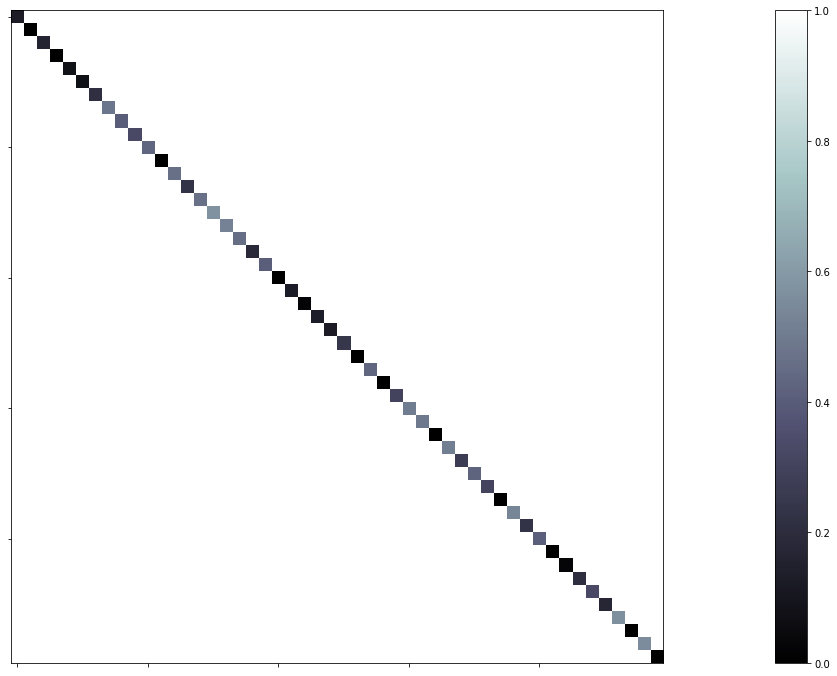

In [ ]:
fig = plt.figure(figsize=(40,12))

ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.imshow(M2[0:50,0:50], cmap=plt.cm.bone, vmin=0, vmax=1)
ax.set_xticklabels([np.arange(0, 2*np.pi)])
ax.set_yticklabels([np.arange(0, 2*np.pi)])
plt.colorbar()


### PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.metrics import *
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, KFold
pcaPCA = PCA(n_components=3).fit_transform(point_cloudA)
pcaPCA2 = PCA(n_components=3).fit_transform(point_cloudA)
pcaPCA3 = PCA(n_components=3).fit_transform(point_cloudA)
pcaPCB = PCA(n_components=3).fit_transform(point_cloudB)
print( "shape after PCA ", pcaPCA.shape)

In [ ]:
point_cloudA

In [ ]:
pcaPCA

In [ ]:
fig = plt.figure(figsize=(30,12))
ax = fig.add_subplot(1, 2, 1, projection='3d')
X = point_cloudA[:,0]
Y = point_cloudA[:,1]
Z = point_cloudA[:,2]
ax.scatter3D(X,Z,Y)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
X = pcaPCA[:,0]
Y = pcaPCA[:,1]
Z = pcaPCA[:,2]
ax.scatter3D(X,Z,Y)
X = point_cloudB[:,0]
Y = point_cloudB[:,1]
Z = point_cloudB[:,2]
ax.scatter3D(X,Z,Y)
X = pcaPCB[:,0]
Y = pcaPCB[:,1]
Z = pcaPCB[:,2]
ax.scatter3D(X,Z,Y)
ax.legend(['point_cloudA','PCApcA', 'point_cloudB', 'PCApcB'])
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
plt.show()